In [87]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from experiment_runner import ExperimentRunner

### Section 1: dataset characteristics– car vs housing results

In [88]:
# Car
car_df = pd.read_csv("car.csv") 
car_target_column = 'Selling_Price' 
car_experiment_runner = ExperimentRunner(car_df, car_target_column)
# Compute subset characteristics (dimensions, variance, skewness)
car_characteristics = car_experiment_runner.compute_characteristics(car_df)

# Housing
housing_df = pd.read_csv('housing.csv') 
housing_target_column = 'medv' 
housing_experiment_runner = ExperimentRunner(housing_df, housing_target_column)
# Compute subset characteristics (dimensions, variance, skewness)
housing_characteristics = housing_experiment_runner.compute_characteristics(housing_df)

In [89]:
car_characteristics["range"].median()

np.float64(3.0)

In [90]:
housing_characteristics["range"].median()

np.float64(31.759999999999998)

In [91]:
# Specify the JSON file's path
file_path = 'car_results3.json'

# Open the file and load its content
with open(file_path, 'r') as file:
    data = json.load(file)

# Print the data to verify
print(data)


[{'source': 0.05, 'generated_rows': 0.01, 'indicators': 0, 'target_column': 'Selling_Price', 'subset_characteristics': {'column': {'0': 'Car_Name', '1': 'Year', '2': 'Selling_Price', '3': 'Present_Price', '4': 'Kms_Driven', '5': 'Fuel_Type', '6': 'Seller_Type', '7': 'Transmission', '8': 'Owner'}, 'source_type': {'0': 'object', '1': 'number', '2': 'number', '3': 'number', '4': 'number', '5': 'object', '6': 'object', '7': 'object', '8': 'number'}, 'mean': {'0': 0.22358763138963977, '1': 2013.6, '2': 3.477333333333333, '3': 4.478666666666667, '4': 29052.866666666665, '5': 0.7192247502902439, '6': 0.325068035878219, '7': 0.6396832874257447, '8': 0.2}, 'variance': {'0': 0.012828237450471978, '1': 8.399999999999997, '2': 9.34656380952381, '3': 11.376055238095239, '4': 236969651.83809525, '5': 0.0, '6': 0.0, '7': 0.0, '8': 0.17142857142857149}, 'skew': {'0': 2.308103975514844, '1': -1.0809037900873666, '2': 0.5824478020650273, '3': 0.2508372551872984, '4': 0.3865310964430755, '5': 0, '6': 0, 

In [92]:
results_dict = {
    "proportion data used to generate": [],
    "proportion of rows generated": [],
    "dropped indicator": [],
    "mse": []
}

In [93]:
for result in data:
    results_dict["proportion data used to generate"].append(result["source"])
    results_dict["proportion of rows generated"].append(result["generated_rows"])
    results_dict["dropped indicator"].append(result["indicators"])
    results_dict["mse"].append(result["mse"])

In [94]:
final_output = pd.DataFrame(results_dict)

In [95]:
removed_high_synthetic = final_output[final_output["proportion of rows generated"] != 1]

In [96]:
removed_high_synthetic.head(20)

,proportion data used to generate,proportion of rows generated,dropped indicator,mse
0,0.05,0.01,0,45353.358944
1,0.05,0.01,1,19145.624622
2,0.05,0.10,0,32033.555067
3,0.05,0.10,1,59225.411008
4,0.05,0.50,0,139499.962277
5,0.05,0.50,1,34967.402789
8,0.10,0.01,0,57532.704903
9,0.10,0.01,1,15663.739286
10,0.10,0.10,0,10086.573554
11,0.10,0.10,1,72301.637058


In [97]:
# First do analysis to see how the dropped indicator does anything
not_dropped = removed_high_synthetic[removed_high_synthetic["dropped indicator"] == 0]["mse"].mean()
dropped = removed_high_synthetic[removed_high_synthetic["dropped indicator"] == 1]["mse"].mean()
# Baseline mse
baseline = 52438.91469461845

/var/folders/hh/rn_fsj015zz6cmlmssx4w0y00000gn/T/ipykernel_5918/1049425792.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


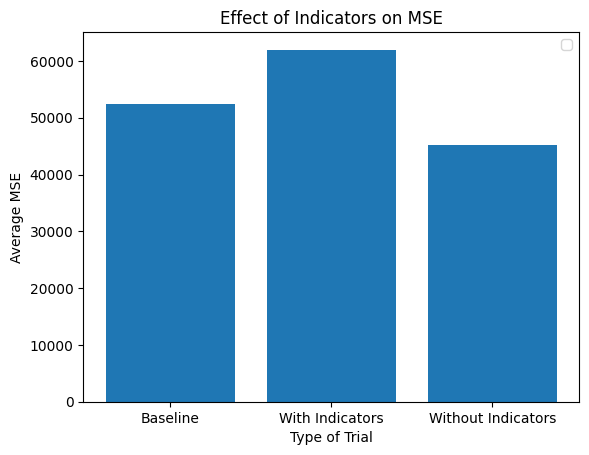

In [98]:
# Data for the bar graph
categories = ['Baseline', 'With Indicators', 'Without Indicators']
values = [baseline, not_dropped, dropped]

# Creating the bar graph
plt.bar(categories, values)
plt.title("Effect of Indicators on MSE")
plt.xlabel("Type of Trial")
plt.ylabel("Average MSE")
plt.legend()
plt.savefig("indicators_vs_avg_mse.png")

### Next we will find how this breaks down for synthetic rows

In [99]:
dropped_df = removed_high_synthetic[removed_high_synthetic["dropped indicator"] == 0]
not_dropped_df = removed_high_synthetic[removed_high_synthetic["dropped indicator"] == 1]

In [100]:
averaged_df_drop = dropped_df.groupby("proportion of rows generated", as_index=False)["mse"].mean()
averaged_df_not_drop = not_dropped_df.groupby("proportion of rows generated", as_index=False)["mse"].mean()

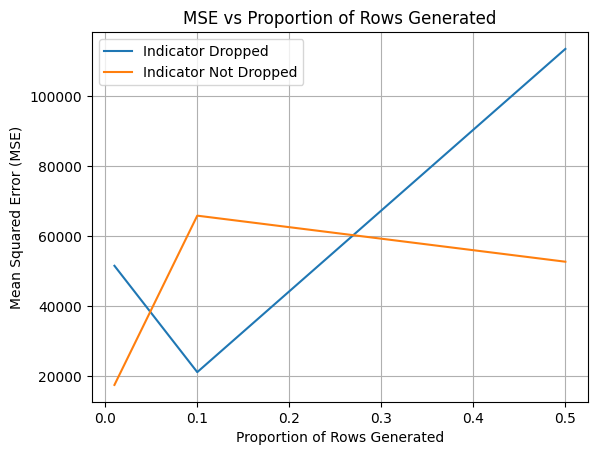

In [101]:
plt.plot(averaged_df_drop["proportion of rows generated"], averaged_df_drop["mse"], label="Indicator Dropped")
plt.plot(averaged_df_not_drop["proportion of rows generated"], averaged_df_not_drop["mse"], label="Indicator Not Dropped")
plt.title('MSE vs Proportion of Rows Generated')
plt.xlabel('Proportion of Rows Generated')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.legend()
plt.savefig("proportion_generated_vs_mse_indicator.png")

### Next see how this same graph is generated if we split over the amount of subset used to make synthetic data

In [102]:
less_data = removed_high_synthetic[removed_high_synthetic["proportion data used to generate"] == 0.05]
more_data = removed_high_synthetic[removed_high_synthetic["proportion data used to generate"] == 0.1]

In [103]:
averaged_less = less_data.groupby("proportion of rows generated", as_index=False)["mse"].mean()
averaged_more = more_data.groupby("proportion of rows generated", as_index=False)["mse"].mean()

In [104]:
averaged_less

,proportion of rows generated,mse
0,0.01,32249.491783
1,0.10,45629.483037
2,0.50,87233.682533


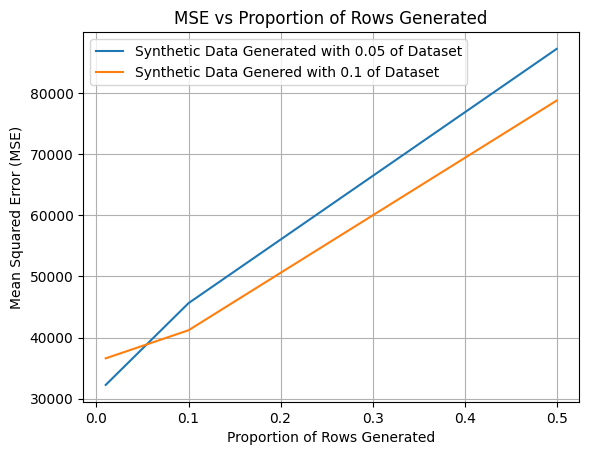

In [105]:
plt.plot(averaged_less["proportion of rows generated"], averaged_less["mse"], label="Synthetic Data Generated with 0.05 of Dataset")
plt.plot(averaged_more["proportion of rows generated"], averaged_more["mse"], label="Synthetic Data Genered with 0.1 of Dataset")
plt.title('MSE vs Proportion of Rows Generated')
plt.xlabel('Proportion of Rows Generated')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.legend()
plt.savefig("proportion_generated_vs_mse_synthetic_input_subset.png")

### Note how the subset characteristics change here

In [106]:
final_output

,proportion data used to generate,proportion of rows generated,dropped indicator,mse
0,0.05,0.01,0,45353.358944
1,0.05,0.01,1,19145.624622
2,0.05,0.10,0,32033.555067
3,0.05,0.10,1,59225.411008
4,0.05,0.50,0,139499.962277
5,0.05,0.50,1,34967.402789
6,0.05,1.00,0,"Trial performed too poorly, very high MSE"
7,0.05,1.00,1,34455.736833
8,0.10,0.01,0,57532.704903
9,0.10,0.01,1,15663.739286


In [111]:
kurtosis_dict = {
    "proportion data used to generate": [],
    "proportion of rows generated": [],
    "subset_kurtosis": [],
    "generated_kurtosis": []
}

In [112]:
for result in data:
    kurtosis_dict["proportion data used to generate"].append(result["source"])
    kurtosis_dict["proportion of rows generated"].append(result["generated_rows"])
    l1 = result["subset_characteristics"]["kurtosis"].values()
    kurtosis_dict["subset_kurtosis"].append(sum(l1) / len(l1))
    l2 = result["generated_characteristics"]["kurtosis"].values()
    kurtosis_dict["generated_kurtosis"].append(sum(l2) / len(l2))


In [117]:
kurtosis_df = pd.DataFrame(kurtosis_dict)

In [118]:
kurtosis_df

,proportion data used to generate,proportion of rows generated,subset_kurtosis,generated_kurtosis
0,0.05,0.01,0.941392,-0.750000
1,0.05,0.01,1.387296,-0.750000
2,0.05,0.10,0.404929,1.041609
3,0.05,0.10,0.483125,2.328442
4,0.05,0.50,0.702204,0.804264
5,0.05,0.50,1.841113,0.537734
6,0.05,1.00,1.747684,0.000000
7,0.05,1.00,1.017906,0.000000
8,0.10,0.01,3.101079,-0.750000
9,0.10,0.01,3.244034,-0.750000


In [120]:
output_table = kurtosis_df.groupby(["proportion data used to generate", "proportion of rows generated"], as_index=False)[["subset_kurtosis", "generated_kurtosis"]].mean()

In [121]:
output_table["percent_decrease_kurtosis"] = ((output_table["subset_kurtosis"] - output_table["generated_kurtosis"]) / output_table["subset_kurtosis"]) * 100

In [127]:
output_table.to_csv(f"car_kurtosis_data.csv", index=False)